### Data Extraction

In [2]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

train_path = "dataset/asl_alphabet_train"
test_path = "dataset/asl_alphabet_test"

def load_train_data(folder_path, limit_per_class=2000):

    images = []
    labels = []
    
    print("Loading training data...")
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if not os.path.isdir(label_path):
            continue
            
        print(f"Loading class: {label}")
        count = 0
        for file in os.listdir(label_path):
            if count >= limit_per_class:
                break
            img_path = os.path.join(label_path, file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (64, 64))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                images.append(img)
                labels.append(label)
                count += 1
        print(f"  - Loaded {count} samples")

    X = np.array(images).reshape(-1, 64, 64, 1) / 255.0
    y = np.array(labels)
    return X, y

def load_test_data(folder_path):

    images = []
    labels = []
    
    print("Loading testing data...")
    for file in os.listdir(folder_path):
        if not file.lower().endswith(('.png', '.jpg', '.jpeg')): 
            continue

        label = os.path.splitext(file)[0][0].upper()
        
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (64, 64))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            images.append(img)
            labels.append(label)

    X = np.array(images).reshape(-1, 64, 64, 1) / 255.0
    y = np.array(labels)
    return X, y

X_train_full, y_train_full = load_train_data(train_path)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

X_test, y_test = load_test_data(test_path)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

np.save('label_encoder.npy', label_encoder.classes_)


y_train_cat = to_categorical(y_train_encoded, num_classes=len(label_encoder.classes_))
y_val_cat = to_categorical(y_val_encoded, num_classes=len(label_encoder.classes_))
y_test_cat = to_categorical(y_test_encoded, num_classes=len(label_encoder.classes_))

train_datagen = ImageDataGenerator(
    rotation_range=30,        
    width_shift_range=0.2,    
    height_shift_range=0.2,   
    shear_range=0.2,          
    zoom_range=0.2,           
    horizontal_flip=True,     
    fill_mode='nearest',      
    brightness_range=[0.8, 1.2], 
    channel_shift_range=10.0  
)

val_datagen = ImageDataGenerator()

train_datagen.fit(X_train)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print("Classes:", label_encoder.classes_)
print("Data preparation complete.")


Loading training data...
Loading class: A
  - Loaded 2000 samples
Loading class: B
  - Loaded 2000 samples
Loading class: C
  - Loaded 2000 samples
Loading class: D
  - Loaded 2000 samples
Loading class: del
  - Loaded 2000 samples
Loading class: E
  - Loaded 2000 samples
Loading class: F
  - Loaded 2000 samples
Loading class: G
  - Loaded 2000 samples
Loading class: H
  - Loaded 2000 samples
Loading class: I
  - Loaded 2000 samples
Loading class: J
  - Loaded 2000 samples
Loading class: K
  - Loaded 2000 samples
Loading class: L
  - Loaded 2000 samples
Loading class: M
  - Loaded 2000 samples
Loading class: N
  - Loaded 2000 samples
Loading class: nothing
  - Loaded 2000 samples
Loading class: O
  - Loaded 2000 samples
Loading class: P
  - Loaded 2000 samples
Loading class: Q
  - Loaded 2000 samples
Loading class: R
  - Loaded 2000 samples
Loading class: S
  - Loaded 2000 samples
Loading class: space
  - Loaded 2000 samples
Loading class: T
  - Loaded 2000 samples
Loading class: U
  -

### Training

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder

print("Creating model...")

model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 1), kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3)) 

model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))  

model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))  

model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))  
model.add(BatchNormalization())
model.add(Dropout(0.5)) 
model.add(Dense(y_train_cat.shape[1], activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=0.00005),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),  
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00001)  
]


print("Training model...")
history = model.fit(
    train_datagen.flow(X_train, y_train_cat, batch_size=32), 
    validation_data=(X_val, y_val_cat),  
    epochs=30,  
    callbacks=callbacks
)

test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"Test accuracy: {test_acc:.4f}")

model.save('model.keras')

Creating model...


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,394,109 (9.13 MB)

 Trainable params: 2,392,701 (9.13 MB)

 Non-trainable params: 1,408 (5.50 KB)

Training model...
Epoch 1/50
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 1142s 780ms/step - accuracy: 0.0654 - loss: 4.2280 - val_accuracy: 0.2194 - val_loss: 2.6918 - learning_rate: 5.0000e-05
Epoch 2/50
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 990s 682ms/step - accuracy: 0.1842 - loss: 3.0721 - val_accuracy: 0.2552 - val_loss: 2.4778 - learning_rate: 5.0000e-05
Epoch 3/50
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 1075s 741ms/step - accuracy: 0.2865 - loss: 2.4871 - val_accuracy: 0.1531 - val_loss: 4.7158 - learning_rate: 5.0000e-05
Epoch 4/50
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 985s 679ms/step - accuracy: 0.3634 - loss: 2.1123 - val_accuracy: 0.1810 - val_loss: 3.7772 - learning_rate: 5.0000e-05
Epoch 5/50
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 1300s 897ms/step - accuracy: 0.4235 - loss: 1.8619 - val_accuracy: 0.5986 - val_loss: 1.2894 - learning_rate: 5.0000e-05
Epoch 6/50
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 1227s 846ms/step - accuracy: 0.4887 - loss: 1.6271 - val_accuracy: 0.2503 - val_loss: 3.3636 - learning_rate: 5.0000e-05
Epoch 

In [ ]:
plt.figure(figsize=(12, 4))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"Test accuracy: {test_acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
[0 1 1 1 1 1 1 2 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 0 1 0 1 2]


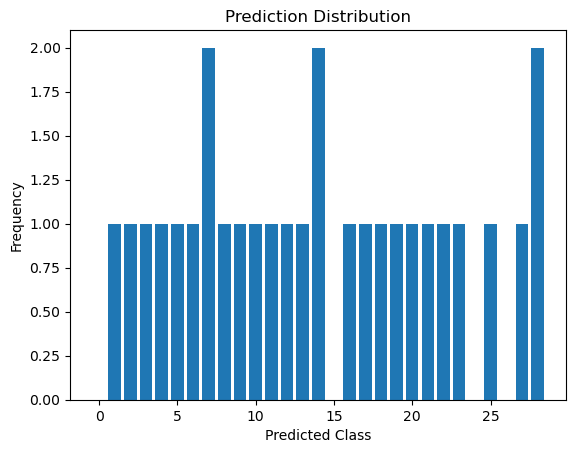

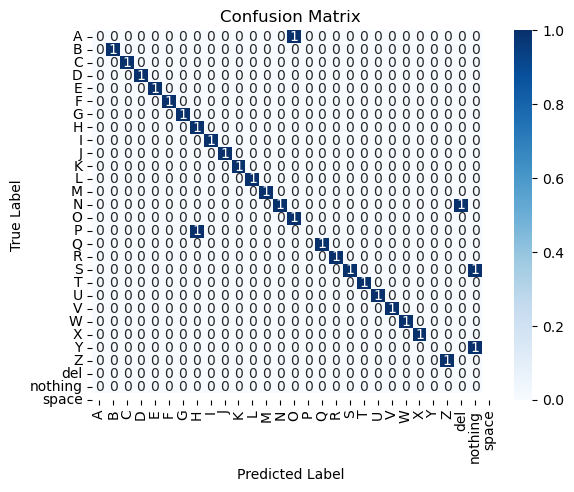

In [14]:
import matplotlib.pyplot as plt

preds = model.predict(X_test)
top_preds = np.argmax(preds, axis=1)
print(np.bincount(top_preds))

plt.bar(range(len(np.bincount(top_preds))), np.bincount(top_preds))
plt.xlabel('Predicted Class')
plt.ylabel('Frequency')
plt.title('Prediction Distribution')
plt.show()



from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = y_test_encoded
# y_true: true labels (int), top_preds: predicted labels (int)
cm = confusion_matrix(y_true, top_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)


plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Real time Detection

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import time
import pyttsx3
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import os


engine = pyttsx3.init()

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

def load_model_and_labels(model_path='model.keras', label_path='label_encoder.npy'):
    if not (os.path.exists(model_path) and os.path.exists(label_path)):
        raise FileNotFoundError("Model or label encoder file not found.")
    
    model = load_model(model_path)
    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.load(label_path, allow_pickle=True)
    return model, label_encoder

def preprocess_roi(roi):
    roi = cv2.resize(roi, (64, 64))
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    normalized = gray / 255.0
    reshaped = normalized.reshape(1, 64, 64, 1)
    return reshaped

def extract_hand_roi(frame, hands_processor):
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands_processor.process(rgb)
    if results.multi_hand_landmarks:
        landmarks = results.multi_hand_landmarks[0]
        mp_drawing.draw_landmarks(frame, landmarks, mp_hands.HAND_CONNECTIONS,
                                  mp_drawing_styles.get_default_hand_landmarks_style(),
                                  mp_drawing_styles.get_default_hand_connections_style())

        h, w, _ = frame.shape
        x_min, y_min = w, h
        x_max, y_max = 0, 0
        for lm in landmarks.landmark:
            x, y = int(lm.x * w), int(lm.y * h)
            x_min, y_min = min(x_min, x), min(y_min, y)
            x_max, y_max = max(x_max, x), max(y_max, y)

        padding = 20
        x_min, y_min = max(0, x_min - padding), max(0, y_min - padding)
        x_max, y_max = min(w, x_max + padding), min(h, y_max + padding)

        box_size = max(x_max - x_min, y_max - y_min, 100)
        center_x = (x_min + x_max) // 2
        center_y = (y_min + y_max) // 2
        x_min, y_min = max(0, center_x - box_size // 2), max(0, center_y - box_size // 2)
        x_max, y_max = min(w, center_x + box_size // 2), min(h, center_y + box_size // 2)

        roi = frame[y_min:y_max, x_min:x_max]
        if roi.size > 0:
            return roi, True, (x_min, y_min)
    return None, False, (0, 0)

def real_time_detection(model, label_encoder):
    cap = cv2.VideoCapture(0)
    current_word, last_letter = "", ""
    letter_buffer, buffer_size = [], 5
    space_triggered, letter_count = False, 0
    no_detection_count, last_letter_time = 0, time.time()
    confidence_threshold = 0.75  

    with mp_hands.Hands(static_image_mode=False, max_num_hands=1,
                        min_detection_confidence=0.7, min_tracking_confidence=0.5) as hands:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.flip(frame, 1)

            roi, detected, (x, y) = extract_hand_roi(frame, hands)
            if detected:
                reshaped = preprocess_roi(roi)
                prediction = model.predict(reshaped, verbose=0)

                predicted_class = np.argmax(prediction)
                confidence = prediction[0][predicted_class]
                predicted_letter = label_encoder.inverse_transform([predicted_class])[0]

          
                letter_buffer.append(predicted_letter)
                if len(letter_buffer) > buffer_size:
                    letter_buffer.pop(0)
                stable_letter = max(set(letter_buffer), key=letter_buffer.count)
                stable_count = letter_buffer.count(stable_letter)

                if confidence > confidence_threshold and stable_count >= buffer_size * 0.6:
                    current_time = time.time()
                    if stable_letter != last_letter and stable_letter != "nothing" and (current_time - last_letter_time > 1.0):
                        if stable_letter == "space":
                            current_word += " "
                            space_triggered = True
                        elif stable_letter == "del":
                            current_word = current_word[:-1]
                        else:
                            current_word += stable_letter
                            last_letter = stable_letter
                            letter_count += 1
                        last_letter_time = current_time

                        if space_triggered:
                            engine.say(current_word.strip())
                            engine.runAndWait()
                            space_triggered = False
                    no_detection_count = 0
                else:
                    no_detection_count += 1
                    if no_detection_count > 30:
                        last_letter = ""
                        no_detection_count = 0

                cv2.putText(frame, f"{predicted_letter} ({confidence:.2f})", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

            cv2.putText(frame, f"Word: {current_word}", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
            cv2.putText(frame, "Press 'q' to quit, 'c' to clear", (10, frame.shape[0] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
            cv2.imshow("ASL Predictor", frame)

            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
            elif key == ord('c'):
                current_word, last_letter = "", ""
                letter_buffer.clear()

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    model, label_encoder = load_model_and_labels()
    real_time_detection(model, label_encoder)


### Testing on images directly from test folder

In [2]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model

model = load_model('model.keras')
label_classes = np.load('label_encoder.npy')

img_path = "dataset/asl_alphabet_test/A_test.jpg"  
img = cv2.imread(img_path)
img = cv2.resize(img, (64, 64))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img.reshape(1, 64, 64, 1) / 255.0  

predictions = model.predict(img)
confidence = np.max(predictions)
predicted_index = np.argmax(predictions)
predicted_label = label_classes[predicted_index]

print(f"\nPrediction Probabilities for each class:")
for i, prob in enumerate(predictions[0]):
    print(f"Class {label_classes[i]}: {prob:.4f}")

print("\nHighest Confidence Prediction:")
print(f"Predicted Label: {predicted_label}")
print(f"Confidence: {confidence:.4f}")

if confidence < 0.85:
    print("Model is not confident in this prediction.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step

Prediction Probabilities for each class:
Class A: 0.9998
Class B: 0.0000
Class C: 0.0000
Class D: 0.0000
Class E: 0.0002
Class F: 0.0000
Class G: 0.0000
Class H: 0.0000
Class I: 0.0000
Class J: 0.0000
Class K: 0.0000
Class L: 0.0000
Class M: 0.0000
Class N: 0.0000
Class O: 0.0000
Class P: 0.0000
Class Q: 0.0000
Class R: 0.0000
Class S: 0.0000
Class T: 0.0000
Class U: 0.0000
Class V: 0.0000
Class W: 0.0000
Class X: 0.0000
Class Y: 0.0000
Class Z: 0.0000

Highest Confidence Prediction:
Predicted Label: A
Confidence: 0.9998


In [4]:
import numpy as np

classes = np.load('label_encoder.npy')
print("Class Index Mapping:")
for i, label in enumerate(classes):
    print(f"{i}: {label}")


Class Index Mapping:
0: A
1: B
2: C
3: D
4: E
5: F
6: G
7: H
8: I
9: J
10: K
11: L
12: M
13: N
14: O
15: P
16: Q
17: R
18: S
19: T
20: U
21: V
22: W
23: X
24: Y
25: Z
26: del
27: nothing
28: space


In [7]:
import cv2
import numpy as np

def preprocess_test_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (64, 64))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255.0
    img = img.reshape(1, 64, 64, 1)
    return img

# Loop through all alphabets A-Z
for label in list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"):
    try:
        test_img = preprocess_test_image(f'dataset/asl_alphabet_test/{label}_test.jpg')
        prediction = model.predict(test_img)
        predicted_index = np.argmax(prediction)
        predicted_label = classes[predicted_index]
        print(f"Actual: {label}, Predicted: {predicted_label}, Confidence: {prediction[0][predicted_index]:.4f}")
    except Exception as e:
        print(f"Error processing {label}: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Actual: A, Predicted: A, Confidence: 0.9998
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Actual: B, Predicted: B, Confidence: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Actual: C, Predicted: C, Confidence: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Actual: D, Predicted: D, Confidence: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Actual: E, Predicted: E, Confidence: 0.9995
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Actual: F, Predicted: F, Confidence: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Actual: G, Predicted: G, Confidence: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Actual: H, Predicted: H, Confidence: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Actual: I, Predicted: I, Confidence: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Actual: J, Predicted: J, Confidence: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Actual: K, Predicted: K, Confidence: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Actual: L, Predicted: L, Confidence: 1.0000
1/1 ━━━━━━━━━━